In [1]:
from google.colab import drive
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Yêu cầu quyền truy cập vào Google Drive
drive.mount('/content/drive', force_remount = True)

# Đường dẫn thư mục project
project_dir = '/content/drive/My Drive/Project II/'

# Kiểm tra xem project_dir có tồn tại không trước khi thay đổi thư mục làm việc
if os.path.exists(project_dir):
    os.chdir(project_dir)
    print("Nội dung trong thư mục:")
    print(os.listdir())  # Liệt kê nội dung thư mục
else:
    print(f"Thư mục không tồn tại: {project_dir}")

Mounted at /content/drive
Nội dung trong thư mục:
['preprocess', 'data', 'models', 'notebooks']


# **1. Khai báo thư viện**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss

import scipy.sparse as sp
import random
from scipy.special import expit
from tqdm import tqdm
from collections import defaultdict

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === NeuMF ===
model_dir = '/content/drive/My Drive/Project II/models/ckpt/neumf_leave_one_last.pth'

# **2. Load và chuẩn bị dữ liệu**

In [4]:
# Load dữ liệu
data_dir = project_dir + "data/"
dataset = pd.read_csv(data_dir + "recommendations_processed.csv").copy()  # Thêm .copy() để tạo bản sao rõ ràng

# Explicitly convert 'date' column to datetime objects
dataset['date'] = pd.to_datetime(dataset['date'])

# Loại trừ duplicate
dataset = dataset.sort_values("date")  # Sort theo thời gian
dataset = dataset.drop_duplicates(subset=['user_id', 'app_id'], keep='last')

# Mapping user_id, game_id sang user_index, game_index
all_user_ids = dataset['user_id'].unique()
all_game_ids = dataset['app_id'].unique()

user_id_mapping = {user_id: idx for idx, user_id in enumerate(sorted(all_user_ids))}
game_id_mapping = {item_id: idx for idx, item_id in enumerate(sorted(all_game_ids))}

# Cập nhật lại user_id, app_id sử dụng .loc
dataset.loc[:, 'user_id'] = dataset['user_id'].map(user_id_mapping)
dataset.loc[:, 'app_id'] = dataset['app_id'].map(game_id_mapping)

## **2.1. Chia dataset theo chiến lược Leave One Last**

In [5]:
def split_data_leave_one_last(df):
    df = df.copy().reset_index(names='original_index')
    test_indices = []

    for _, group in df.groupby("user_id"):
        group_sorted = group.sort_values("date")
        is_rec = group_sorted["is_recommended"].values
        idx = group_sorted.index.values
        for i in range(len(is_rec) - 1, -1, -1):
            if is_rec[i] == 1:
                test_indices.extend(idx[i:])
                break

    test_set = df.loc[test_indices].reset_index(drop=True)
    train_set = df.drop(index=test_indices).reset_index(drop=True)
    test_set = test_set.drop(columns=["original_index"])
    train_set = train_set.drop(columns=["original_index"])
    return train_set, test_set

train_df, test_df = split_data_leave_one_last(dataset)
train_df, valid_df = split_data_leave_one_last(train_df)

print(f"train_df: {train_df.shape}")
print(f"valid_df: {valid_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (2409713, 8)
valid_df: (64265, 8)
test_df: (61055, 8)


## **2.2. Thống kê dataset đơn giản**

In [6]:
# Số lượng users, games
num_users = len(all_user_ids)
num_games = len(all_game_ids)
num_nodes = num_users + num_games

print(f"Số lượng users: {num_users}")
print(f"Số lượng games: {num_games}")
print(f"Số lượng nodes: {num_nodes}")

# Print cold-start statistics
train_users = set(train_df['user_id'].unique())
train_items = set(train_df['app_id'].unique())

valid_users = set(valid_df['user_id'].unique())
valid_items = set(valid_df['app_id'].unique())

test_users = set(test_df['user_id'].unique())
test_items = set(test_df['app_id'].unique())

valid_cold_start_users = valid_users - train_users
valid_cold_start_items = valid_items - train_items
test_cold_start_users = test_users - train_users
test_cold_start_items = test_items - train_items

print("\n=== Cold-start analysis in valid ===")
print(f"Total users in valid: {len(valid_users)}")
print(f"--> Cold-start users in valid: {len(valid_cold_start_users)}")
print(f"Total items in valid: {len(valid_items)}")
print(f"--> Cold-start games in valid: {len(valid_cold_start_items)}")

print("\n=== Cold-start analysis in test ===")
print(f"Total users in test: {len(test_users)}")
print(f"--> Cold-start users in test: {len(test_cold_start_users)}")
print(f"Total items in test: {len(test_items)}")
print(f"--> Cold-start games in test: {len(test_cold_start_items)}")

Số lượng users: 47274
Số lượng games: 4632
Số lượng nodes: 51906

=== Cold-start analysis in valid ===
Total users in valid: 47274
--> Cold-start users in valid: 0
Total items in valid: 4128
--> Cold-start games in valid: 1

=== Cold-start analysis in test ===
Total users in test: 47274
--> Cold-start users in test: 0
Total items in test: 3903
--> Cold-start games in test: 1


# **3. Định nghĩa các hàm tiện ích**

## **3.1. Các lớp bao dữ liệu**

In [7]:
class Data:
    def __init__(self, pos_users, pos_items, all_neg_items, user_to_idx):
        self.pos_users = pos_users
        self.pos_items = pos_items
        self.all_neg_items = all_neg_items
        self.user_to_idx = user_to_idx

class LeaveOneData:
  def __init__(self, labels, train_interactions, user_ids, eval_mask, game_list):
    self.labels = labels
    self.train_interactions = train_interactions
    self.user_ids = user_ids
    self.eval_mask = eval_mask
    self.game_list = game_list

## **3.2. Hàm xây dựng ma trận tương tác user-item**

In [8]:
def create_interact_matrix(dataset: pd.DataFrame, num_users: int, num_items: int) -> torch.BoolTensor:
    # Chỉ lấy các tương tác positive trên toàn bộ dataset
    pos_df = dataset[dataset['is_recommended'] == 1]
    rows = pos_df['user_id'].to_numpy()
    cols = pos_df['app_id'].to_numpy()
    data = np.ones_like(rows, dtype=np.bool_)
    mat = sp.coo_matrix((data, (rows, cols)), shape=(num_users, num_items))
    return torch.from_numpy(mat.toarray())  # dtype=bool mặc định

full_matrix = create_interact_matrix(dataset, num_users, num_games)
train_matrix = create_interact_matrix(train_df, num_users, num_games)
valid_matrix = create_interact_matrix(valid_df, num_users, num_games)

## **3.3. Hàm định nghĩa các Ranking Metrics**

In [9]:
def precision_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return hits.sum(dim=1) / k

def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    relevant = labels.sum(dim=1).clamp(min=1e-8)  # avoid divide by zero
    return hits.sum(dim=1) / relevant

def ndcg_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    device = scores.device
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)

    weights = torch.log2(torch.arange(2, k + 2, device=device).float())
    dcg = (hits / weights).sum(dim=1)

    ideal_len = labels.sum(dim=1).clamp(max=k).long()
    idcg = torch.stack([
        (1.0 / weights[:L]).sum() if L > 0 else torch.tensor(0.0, device=device)
        for L in ideal_len
    ])
    return dcg / idcg.clamp(min=1e-8)

def hitrate_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return (hits.sum(dim=1) > 0).float()

## **3.4. Hàm mất mát BPR**

In [10]:
class BPRLoss(_Loss):
    def __init__(self, lambda_reg: float = 1e-3):
        super().__init__()
        self.lambda_reg = lambda_reg

    def forward(self,
                pos_score: torch.Tensor,
                neg_score: torch.Tensor,
                parameters: torch.Tensor = None) -> torch.Tensor:
        """
        pos_score: [batch_size]
        neg_score: [batch_size, num_neg]
        parameters: embedding cần regularize
        """
        # Ensure pos_score has shape [batch_size, 1] for broadcasting
        if pos_score.dim() == 1:
            pos_score = pos_score.unsqueeze(1)  # [batch_size, 1]

        log_prob = F.logsigmoid(pos_score - neg_score).mean()

        regularization = 0
        if self.lambda_reg != 0 and parameters is not None:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)
            regularization = regularization / pos_score.size(0)

        return -log_prob + regularization

# **4. Định nghĩa mô hình NeuMF**

In [11]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, layers, dropout):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items

        # GMF embeddings
        self.user_emb_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_emb_gmf = nn.Embedding(num_items, embedding_dim)

        # MLP embeddings
        self.user_emb_mlp = nn.Embedding(num_users, layers[0] // 2)
        self.item_emb_mlp = nn.Embedding(num_items, layers[0] // 2)

        # MLP layers
        mlp = []
        for i in range(len(layers) - 1):
            mlp.append(nn.Linear(layers[i], layers[i+1]))
            mlp.append(nn.ReLU())
            if dropout:
                mlp.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*mlp)

        # Prediction layer
        self.head = nn.Linear(layers[-1] + embedding_dim, 1)

        self._init_weights()

    def _init_weights(self):
        # Initialize embeddings
        nn.init.normal_(self.user_emb_gmf.weight, std=0.01)
        nn.init.normal_(self.item_emb_gmf.weight, std=0.01)
        nn.init.normal_(self.user_emb_mlp.weight, std=0.01)
        nn.init.normal_(self.item_emb_mlp.weight, std=0.01)

        # Initialize MLP layers
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

        # Initialize prediction layer
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, user_idx, item_idx):
        # GMF path
        user_emb_gmf = self.user_emb_gmf(user_idx)  # [batch_size, embedding_dim]
        item_emb_gmf = self.item_emb_gmf(item_idx)  # [batch_size, embedding_dim]
        gmf_vector = user_emb_gmf * item_emb_gmf    # [batch_size, embedding_dim]

        # MLP path
        user_emb_mlp = self.user_emb_mlp(user_idx)  # [batch_size, layers[0]//2]
        item_emb_mlp = self.item_emb_mlp(item_idx)  # [batch_size, layers[0]//2]
        mlp_vector = torch.cat([user_emb_mlp, item_emb_mlp], dim=1)  # [batch_size, layers[0]]
        mlp_vector = self.mlp(mlp_vector)  # [batch_size, layers[-1]]

        # Combine paths
        vector = torch.cat([gmf_vector, mlp_vector], dim=1)  # [batch_size, layers[-1] + embedding_dim]
        scores = self.head(vector).squeeze(-1)  # [batch_size]
        return scores

    def compute_bpr_loss(self, pos_scores: torch.Tensor,
                         neg_scores: torch.Tensor,
                         lambda_reg: float = 1e-3) -> torch.Tensor:
        loss_fn = BPRLoss(lambda_reg=lambda_reg)

        all_params = []
        for param in self.parameters():
            if param.requires_grad:
                all_params.append(param.view(-1))

        concatenated_params = torch.cat(all_params) if all_params else None
        return loss_fn(pos_scores, neg_scores, concatenated_params)

# **5. Huấn luyện mô hình**

## **5.1. Định nghĩa hàm train**

In [12]:
def train(model, train_data, train_loader, scheduler, optimizer, device, lambda_reg=1e-3, criterion='bpr', num_neg=3):
    model.train()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    pos_users = train_data.pos_users.to(device)
    pos_items = train_data.pos_items.to(device)
    all_neg_items = train_data.all_neg_items.to(device)
    user_to_train_idx = train_data.user_to_idx

    for batch_index in tqdm(train_loader, desc="Training", leave=False):
        # === Positive Samples ===
        batch_pos_users = pos_users[batch_index]
        batch_pos_items = pos_items[batch_index]
        batch_size = batch_pos_users.size(0)

        # === Negative Sampling ===
        batch_train_indices = torch.tensor(
            [user_to_train_idx[u.item()] for u in batch_pos_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_train_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_pos_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = neg_items.reshape(-1)  # [batch_size * num_neg]

        # === Compute scores ===
        pos_scores = model(batch_pos_users, batch_pos_items)  # [batch_size]  # Use batch_pos_items instead of batch_neg_items
        neg_scores = model(batch_neg_users, batch_neg_items)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        optimizer.zero_grad()
        if criterion == 'bpr':
            loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                        neg_scores=neg_scores,
                                        lambda_reg=lambda_reg)
        else:
            raise ValueError(f"Unknown Loss Type: {criterion}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    scheduler.step()
    train_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return train_loss

## **5.2. Định nghĩa hàm validate**

In [13]:
@torch.no_grad()
def validate(model, valid_data, valid_loader, device, criterion='bpr', num_neg=3):
    model.eval()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    pos_users = valid_data.pos_users.to(device)
    pos_items = valid_data.pos_items.to(device)
    all_neg_items = valid_data.all_neg_items.to(device)
    user_to_valid_idx = valid_data.user_to_idx

    for batch_index in tqdm(valid_loader, desc="Validating", leave=False):
        # === Positive Samples ===
        batch_pos_users = pos_users[batch_index]
        batch_pos_items = pos_items[batch_index]
        batch_size = batch_pos_users.size(0)

        # === Negative Sampling ===
        batch_valid_indices = torch.tensor(
            [user_to_valid_idx[u.item()] for u in batch_pos_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_valid_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_pos_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = neg_items.reshape(-1)  # [batch_size * num_neg]

        # === Compute scores ===
        pos_scores = model(batch_pos_users, batch_pos_items)  # [batch_size]  # Use batch_pos_items instead of batch_neg_items
        neg_scores = model(batch_neg_users, batch_neg_items)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        # === Compute loss ===
        loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                    neg_scores=neg_scores,
                                    lambda_reg=0.0)

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    valid_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return valid_loss

## **5.3. Định nghĩa hàm evaluate**

In [29]:
@torch.no_grad()
def evaluate_ranking_leave_one_last(model, test_data, device, k=10, batch_size=4096):
    """
    Evaluate model using leave-one-last strategy.
    For each user:
    - One recent positive item
    - 100 random negative items
    """
    model.eval()
    num_users = model.num_users
    num_items = model.num_items

    # Get test data
    test_labels = test_data.labels
    train_interactions = test_data.train_interactions
    user_ids = test_data.user_ids
    eval_mask = test_data.eval_mask
    game_list = test_data.game_list

    # Ensure eval_mask matches the number of items
    if eval_mask.size(1) != num_items:
        eval_mask = eval_mask[:, :num_items]

    # Metrics storage
    all_ndcg = []
    all_hit = []

    num_test = user_ids.size(0)

    # Process in smaller batches
    for start in tqdm(range(0, num_test, batch_size), desc="Evaluating", leave=False):
        end = min(start + batch_size, num_test)
        batch_idx = slice(start, end)
        batch_user_ids = user_ids[batch_idx]
        batch_size = batch_user_ids.size(0)

        # Get batch eval mask and ensure dimensions match
        batch_eval_mask = eval_mask[batch_idx]
        if batch_eval_mask.size(1) != num_items:
            batch_eval_mask = batch_eval_mask[:, :num_items]

        # Initialize scores tensor with the same size as eval_mask
        batch_scores = torch.empty((batch_size, batch_eval_mask.size(1)), device=device)

        # Process items in smaller chunks to save memory
        item_chunk_size = 1024  # Reduced chunk size
        for item_start in range(0, batch_eval_mask.size(1), item_chunk_size):
            item_end = min(item_start + item_chunk_size, batch_eval_mask.size(1))
            chunk_size = item_end - item_start

            # Create user-item pairs for this chunk
            batch_users = batch_user_ids.unsqueeze(1).expand(-1, chunk_size)
            chunk_items = torch.arange(item_start, item_end, device=device)
            chunk_items = chunk_items.unsqueeze(0).expand(batch_size, -1)

            # Process GMF path
            user_emb_gmf = model.user_emb_gmf(batch_users)  # [batch_size, chunk_size, embedding_dim]
            item_emb_gmf = model.item_emb_gmf(chunk_items)  # [batch_size, chunk_size, embedding_dim]
            gmf_vector = user_emb_gmf * item_emb_gmf  # [batch_size, chunk_size, embedding_dim]

            # Process MLP path in smaller sub-chunks to save memory
            sub_chunk_size = 10
            mlp_vectors = []

            for sub_start in range(0, chunk_size, sub_chunk_size):
                sub_end = min(sub_start + sub_chunk_size, chunk_size)
                sub_size = sub_end - sub_start

                # Get embeddings for sub-chunk
                sub_users = batch_users[:, sub_start:sub_end]
                sub_items = chunk_items[:, sub_start:sub_end]

                user_emb_mlp = model.user_emb_mlp(sub_users)
                item_emb_mlp = model.item_emb_mlp(sub_items)

                # Concatenate and process through MLP
                sub_mlp_vector = torch.cat([user_emb_mlp, item_emb_mlp], dim=2)
                sub_mlp_vector = model.mlp(sub_mlp_vector)
                mlp_vectors.append(sub_mlp_vector)

                # Clear memory
                del user_emb_mlp, item_emb_mlp, sub_mlp_vector
                torch.cuda.empty_cache()

            # Combine MLP vectors
            mlp_vector = torch.cat(mlp_vectors, dim=1)
            del mlp_vectors
            torch.cuda.empty_cache()

            # Combine paths
            vector = torch.cat([gmf_vector, mlp_vector], dim=2)
            chunk_scores = model.head(vector).squeeze(-1)

            # Store scores
            batch_scores[:, item_start:item_end] = chunk_scores

            # Clear memory
            del gmf_vector, mlp_vector, vector, chunk_scores
            torch.cuda.empty_cache()

        # Mask out items not in evaluation set
        batch_scores = batch_scores.masked_fill(~batch_eval_mask, -float('inf'))
        batch_labels = test_labels[batch_idx]

        # Ensure labels match the number of items
        if batch_labels.size(1) != batch_eval_mask.size(1):
            batch_labels = batch_labels[:, :batch_eval_mask.size(1)]

        # Skip users with no positive labels
        valid_users = batch_labels.sum(dim=1) > 0
        if not valid_users.any():
            continue

        batch_scores = batch_scores[valid_users]
        batch_labels = batch_labels[valid_users]

        # Compute metrics
        ndcg = ndcg_at_k(batch_scores, batch_labels, k)
        hitrate = hitrate_at_k(batch_scores, batch_labels, k)

        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

        # Clear memory
        del batch_scores, batch_labels
        torch.cuda.empty_cache()

    # Compute average metrics
    avg_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    avg_hit = torch.cat(all_hit).mean().item() if all_hit else 0.0

    return {
        f"NDCG@{k}": avg_ndcg,
        f"HitRate@{k}": avg_hit
    }

## **5.4. Train Loss, Valid Loss, NDCG@10, HitRate@10**

### **5.4.1. Chuẩn bị dữ liệu trước khi huấn luyện**

In [15]:
# Create mapping from global user indices to training user indices
train_users_tensor = torch.tensor(list(train_users), dtype=torch.long)
train_num_users = train_users_tensor.size(0)
user_to_train_idx = {u.item(): i for i, u in enumerate(train_users_tensor)}

# Extract positive interactions from train_df
train_pos_df = train_df[train_df['is_recommended'] == 1]
train_pos_users = torch.tensor(train_pos_df['user_id'].values, dtype=torch.long)
train_pos_items = torch.tensor(train_pos_df['app_id'].values, dtype=torch.long)

# Pre-compute all possible negative items for each user in train dataset
train_all_neg_items = torch.zeros((train_num_users, num_games), dtype=torch.bool)
for i, u in enumerate(train_users_tensor):
    train_all_neg_items[i] = ~full_matrix[u]

# Create Data object
train_data = Data(
    pos_users=train_pos_users,
    pos_items=train_pos_items,
    all_neg_items=train_all_neg_items,
    user_to_idx=user_to_train_idx
)

In [16]:
valid_users_in_matrix = torch.tensor(list(valid_users), dtype=torch.long)
valid_num_users = valid_users_in_matrix.size(0)
user_to_valid_idx = {u.item(): i for i, u in enumerate(valid_users_in_matrix)}

# Extract positive interactions from valid_df
valid_pos_df = valid_df[valid_df['is_recommended'] == 1]
valid_pos_users = torch.tensor(valid_pos_df['user_id'].values, dtype=torch.long)
valid_pos_items = torch.tensor(valid_pos_df['app_id'].values, dtype=torch.long)

# Pre-compute negative items for validation dataset
valid_all_neg_items = torch.zeros((valid_num_users, num_games), dtype=torch.bool)
# Iterate through the mapped user IDs present in the validation matrix
for i, mapped_user_id in enumerate(valid_users_in_matrix):
    # Use the mapped_user_id to index the full_matrix (or valid_matrix if preferred, but full_matrix is consistent with train)
    valid_all_neg_items[i] = ~full_matrix[mapped_user_id]

# Create Data object
valid_data = Data(
    pos_users=valid_pos_users,
    pos_items=valid_pos_items,
    all_neg_items=valid_all_neg_items,
    user_to_idx=user_to_valid_idx
)

In [30]:
# Create data loader
train_loader = DataLoader(
    dataset = range(len(train_data.pos_users)),
    batch_size = 8192,
    shuffle = True,
    num_workers = 2,
    pin_memory=True
)

# Create data loader
valid_loader = DataLoader(
    dataset=range(len(valid_data.pos_users)),
    batch_size=8192,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [18]:
def create_leave_one_last_data(train_df, test_df, device, num_neg_samples=100):
    """
    Create test data for leave-one-last evaluation strategy.
    For each user:
    - One recent positive item from test set
    - 100 random negative items from training set
    """
    # Get unique games from training set
    game_list = sorted(train_df["app_id"].unique())
    game2idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games = len(game_list)

    # Get test users and their positive items
    test_users = test_df["user_id"].unique()
    user2idx = {user_id: idx for idx, user_id in enumerate(test_users)}
    num_test_users = len(test_users)

    # Create user-item interaction matrix for training
    train_interactions = torch.zeros((num_test_users, num_games), dtype=torch.bool, device=device)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        if user_id in user2idx and game_id in game2idx:
            u_idx = user2idx[user_id]
            g_idx = game2idx[game_id]
            train_interactions[u_idx, g_idx] = True

    # Create test labels (one positive item per user)
    test_labels = torch.zeros((num_test_users, num_games), dtype=torch.float, device=device)
    for user_id, game_id in zip(test_df["user_id"], test_df["app_id"]):
        if user_id in user2idx and game_id in game2idx:
            u_idx = user2idx[user_id]
            g_idx = game2idx[game_id]
            test_labels[u_idx, g_idx] = 1.0

    # Create mask for items to evaluate (positive + 100 negative)
    eval_mask = torch.zeros((num_test_users, num_games), dtype=torch.bool, device=device)

    for i, user_id in enumerate(test_users):
        u_idx = user2idx[user_id]

        # Get positive item from test set
        pos_items = torch.where(test_labels[u_idx] == 1)[0]
        if len(pos_items) > 0:
            eval_mask[u_idx, pos_items[0]] = True

        # Get negative items from training set
        neg_items = torch.where(~train_interactions[u_idx])[0]
        if len(neg_items) >= num_neg_samples:
            # Randomly select num_neg_samples negative items
            selected_neg = neg_items[torch.randperm(len(neg_items))[:num_neg_samples]]
            eval_mask[u_idx, selected_neg] = True

    # Create user IDs tensor
    user_ids_tensor = torch.tensor(test_users, dtype=torch.long, device=device)

    return LeaveOneData(
        labels=test_labels,
        train_interactions=train_interactions,
        user_ids=user_ids_tensor,
        eval_mask=eval_mask,
        game_list=game_list
    )

In [19]:
evaluate_data = create_leave_one_last_data(train_df, valid_df, device)

### **5.4.2. Khởi tạo mô hình và huấn luyện**

In [31]:
model = NeuMF(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64,
    layers = [128, 64, 32],
    dropout = 0.4
).to(device)

print("Tham số của mô hình:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"param_name: {name}, param_size: {param.size()}, requires_grad: {param.requires_grad}")

Tham số của mô hình:
param_name: user_emb_gmf.weight, param_size: torch.Size([47274, 64]), requires_grad: True
param_name: item_emb_gmf.weight, param_size: torch.Size([4632, 64]), requires_grad: True
param_name: user_emb_mlp.weight, param_size: torch.Size([47274, 64]), requires_grad: True
param_name: item_emb_mlp.weight, param_size: torch.Size([4632, 64]), requires_grad: True
param_name: mlp.0.weight, param_size: torch.Size([64, 128]), requires_grad: True
param_name: mlp.0.bias, param_size: torch.Size([64]), requires_grad: True
param_name: mlp.3.weight, param_size: torch.Size([32, 64]), requires_grad: True
param_name: mlp.3.bias, param_size: torch.Size([32]), requires_grad: True
param_name: head.weight, param_size: torch.Size([1, 96]), requires_grad: True
param_name: head.bias, param_size: torch.Size([1]), requires_grad: True


In [32]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 0.0005)
num_epochs = 50

train_losses, valid_losses, ndcgs_10, hitrates_10 = [], [], [], []
best_ndcg_10 = 0.0
best_hitrate_10 = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train(
      model = model,
      train_data = train_data,
      train_loader = train_loader,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device,
      lambda_reg = 1e-3,
      criterion = 'bpr',
      num_neg = 3
    )

    valid_loss = validate(
      model = model,
      valid_data = valid_data,
      valid_loader = valid_loader,
      device = device,
      criterion = 'bpr',
      num_neg = 3
    )

    evaluation_results = evaluate_ranking_leave_one_last(model = model, test_data = evaluate_data, device = device)

    ndcg_10 = evaluation_results["NDCG@10"]
    hitrate_10 = evaluation_results["HitRate@10"]

    print(f"Epoch: {epoch:02d} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | NDCG@10: {ndcg_10:.4f} | HitRate@10: {hitrate_10:.4f}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    ndcgs_10.append(ndcg_10)
    hitrates_10.append(hitrate_10)

    if ndcg_10 > best_ndcg_10 and hitrate_10 > best_hitrate_10:
        best_ndcg_10 = ndcg_10
        best_hitrate_10 = hitrate_10
        if os.path.exists(model_dir):
            os.remove(model_dir)
        torch.save(model.state_dict(), model_dir)
        print("---> Best checkpoint is saved!")

Epoch: 01 | Train Loss: 0.3498 | Valid Loss: 0.3960 | NDCG@10: 0.2494 | HitRate@10: 0.4954
---> Best checkpoint is saved!


Epoch: 02 | Train Loss: 0.2181 | Valid Loss: 0.3677 | NDCG@10: 0.2677 | HitRate@10: 0.5269
---> Best checkpoint is saved!


Epoch: 03 | Train Loss: 0.1785 | Valid Loss: 0.3718 | NDCG@10: 0.2719 | HitRate@10: 0.5314
---> Best checkpoint is saved!


Epoch: 04 | Train Loss: 0.1625 | Valid Loss: 0.3770 | NDCG@10: 0.2741 | HitRate@10: 0.5357
---> Best checkpoint is saved!


Epoch: 05 | Train Loss: 0.1539 | Valid Loss: 0.3905 | NDCG@10: 0.2750 | HitRate@10: 0.5363
---> Best checkpoint is saved!


Epoch: 06 | Train Loss: 0.1484 | Valid Loss: 0.3906 | NDCG@10: 0.2735 | HitRate@10: 0.5326


Epoch: 07 | Train Loss: 0.1449 | Valid Loss: 0.3972 | NDCG@10: 0.2756 | HitRate@10: 0.5353


Epoch: 08 | Train Loss: 0.1425 | Valid Loss: 0.4022 | NDCG@10: 0.2769 | HitRate@10: 0.5351


Epoch: 09 | Train Loss: 0.1398 | Valid Loss: 0.3983 | NDCG@10: 0.2774 | HitRate@10: 0.5383
---> Best checkpoint is saved!


Epoch: 10 | Train Loss: 0.1378 | Valid Loss: 0.4028 | NDCG@10: 0.2766 | HitRate@10: 0.5338


Epoch: 11 | Train Loss: 0.1362 | Valid Loss: 0.4022 | NDCG@10: 0.2788 | HitRate@10: 0.5375


Epoch: 12 | Train Loss: 0.1345 | Valid Loss: 0.4063 | NDCG@10: 0.2774 | HitRate@10: 0.5355


Epoch: 13 | Train Loss: 0.1330 | Valid Loss: 0.4017 | NDCG@10: 0.2783 | HitRate@10: 0.5375


Epoch: 14 | Train Loss: 0.1310 | Valid Loss: 0.4125 | NDCG@10: 0.2774 | HitRate@10: 0.5373


Epoch: 15 | Train Loss: 0.1293 | Valid Loss: 0.4156 | NDCG@10: 0.2802 | HitRate@10: 0.5382


Epoch: 16 | Train Loss: 0.1276 | Valid Loss: 0.4169 | NDCG@10: 0.2797 | HitRate@10: 0.5375


Epoch: 17 | Train Loss: 0.1256 | Valid Loss: 0.4168 | NDCG@10: 0.2813 | HitRate@10: 0.5404
---> Best checkpoint is saved!


Epoch: 18 | Train Loss: 0.1240 | Valid Loss: 0.4119 | NDCG@10: 0.2812 | HitRate@10: 0.5412


Epoch: 19 | Train Loss: 0.1218 | Valid Loss: 0.4141 | NDCG@10: 0.2803 | HitRate@10: 0.5381


Epoch: 20 | Train Loss: 0.1199 | Valid Loss: 0.4149 | NDCG@10: 0.2815 | HitRate@10: 0.5420
---> Best checkpoint is saved!


Epoch: 21 | Train Loss: 0.1179 | Valid Loss: 0.4174 | NDCG@10: 0.2826 | HitRate@10: 0.5419


Epoch: 22 | Train Loss: 0.1157 | Valid Loss: 0.4206 | NDCG@10: 0.2821 | HitRate@10: 0.5409


Epoch: 23 | Train Loss: 0.1138 | Valid Loss: 0.4172 | NDCG@10: 0.2826 | HitRate@10: 0.5411


Epoch: 24 | Train Loss: 0.1115 | Valid Loss: 0.4244 | NDCG@10: 0.2835 | HitRate@10: 0.5433
---> Best checkpoint is saved!


Epoch: 25 | Train Loss: 0.1090 | Valid Loss: 0.4225 | NDCG@10: 0.2841 | HitRate@10: 0.5425


Epoch: 26 | Train Loss: 0.1070 | Valid Loss: 0.4219 | NDCG@10: 0.2850 | HitRate@10: 0.5449
---> Best checkpoint is saved!


Epoch: 27 | Train Loss: 0.1048 | Valid Loss: 0.4298 | NDCG@10: 0.2863 | HitRate@10: 0.5476
---> Best checkpoint is saved!


Epoch: 28 | Train Loss: 0.1022 | Valid Loss: 0.4298 | NDCG@10: 0.2858 | HitRate@10: 0.5456


Epoch: 29 | Train Loss: 0.1004 | Valid Loss: 0.4309 | NDCG@10: 0.2867 | HitRate@10: 0.5458


Epoch: 30 | Train Loss: 0.0981 | Valid Loss: 0.4297 | NDCG@10: 0.2875 | HitRate@10: 0.5471


Epoch: 31 | Train Loss: 0.0957 | Valid Loss: 0.4361 | NDCG@10: 0.2893 | HitRate@10: 0.5500
---> Best checkpoint is saved!


Epoch: 32 | Train Loss: 0.0936 | Valid Loss: 0.4358 | NDCG@10: 0.2894 | HitRate@10: 0.5493


Epoch: 33 | Train Loss: 0.0916 | Valid Loss: 0.4373 | NDCG@10: 0.2905 | HitRate@10: 0.5498


Epoch: 34 | Train Loss: 0.0892 | Valid Loss: 0.4374 | NDCG@10: 0.2895 | HitRate@10: 0.5478


Epoch: 35 | Train Loss: 0.0871 | Valid Loss: 0.4381 | NDCG@10: 0.2905 | HitRate@10: 0.5490


Epoch: 36 | Train Loss: 0.0853 | Valid Loss: 0.4361 | NDCG@10: 0.2908 | HitRate@10: 0.5497


Epoch: 37 | Train Loss: 0.0835 | Valid Loss: 0.4398 | NDCG@10: 0.2916 | HitRate@10: 0.5502
---> Best checkpoint is saved!


Epoch: 38 | Train Loss: 0.0815 | Valid Loss: 0.4468 | NDCG@10: 0.2916 | HitRate@10: 0.5498


KeyboardInterrupt: 

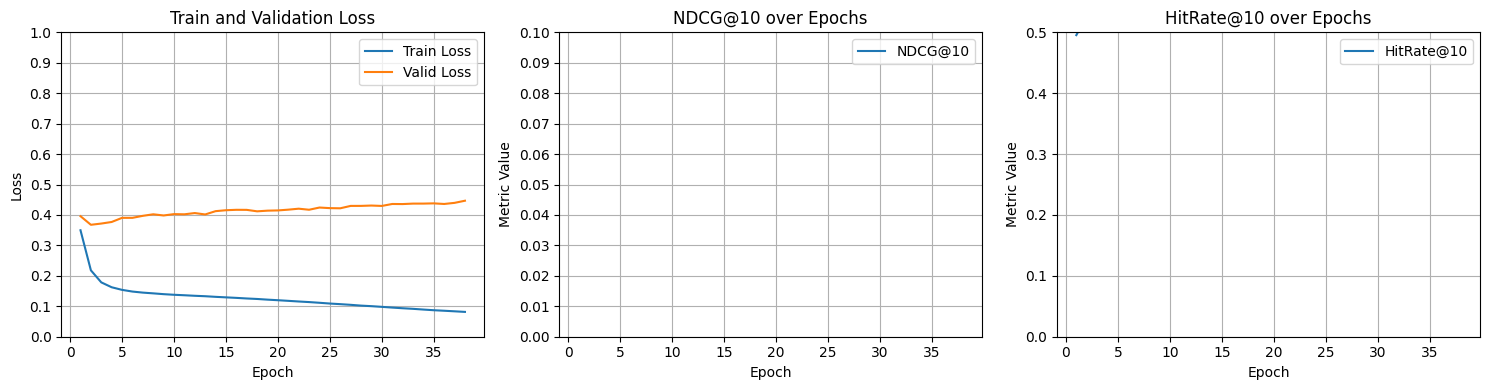

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 hàng, 3 cột

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, len(train_losses) + 1)

# --- Plot 1: Training and Validation Losses ---
axes[0].plot(epochs_range, train_losses, label='Train Loss')
axes[0].plot(epochs_range, valid_losses, label='Valid Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# --- Plot 2: NDCG@10 over Epochs ---
axes[1].plot(epochs_range, ndcgs_10, label='NDCG@10')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('NDCG@10 over Epochs')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0.0, 0.1)
axes[1].set_yticks([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

# --- Plot 3: HitRate@10 over Epochs ---
axes[2].plot(epochs_range, hitrates_10, label='HitRate@10')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('HitRate@10 over Epochs')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.0, 0.5)
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.tight_layout()
plt.show()

# **6. Đánh giá khả năng xếp hạng (ranking)**

In [34]:
model = NeuMF(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64,
    layers = [128, 64, 32],
    dropout = 0.4
)

# Load model with proper device mapping
model.load_state_dict(torch.load(model_dir, map_location=device))
model.to(device)  # Move model to appropriate device

NeuMF(
  (user_emb_gmf): Embedding(47274, 64)
  (item_emb_gmf): Embedding(4632, 64)
  (user_emb_mlp): Embedding(47274, 64)
  (item_emb_mlp): Embedding(4632, 64)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
  )
  (head): Linear(in_features=96, out_features=1, bias=True)
)

In [35]:
test_data = create_leave_one_last_data(train_df, test_df, device)

# Đánh giá dựa trên leave one last
leave_one_last_result = evaluate_ranking_leave_one_last(model, test_data, device)
print("\n--- Leave One Last Ranking Metrics ---")
for metric, value in leave_one_last_result.items():
    print(f"{metric}: {value:.4f}")


--- Leave One Last Ranking Metrics ---
NDCG@10: 0.2551
HitRate@10: 0.4863
